In [1]:
import gymnasium as gym
import os
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure

from evaluation.evalcallback_feedback import CurriculumEvalCallback

from gpt.utils import file_to_string

2024-04-19 14:19:34.305553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 14:19:41.474132: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def load_curriculum_training_log(logger_path):
    training_log = np.load(logger_path + "/evaluations.npz", allow_pickle=True)

    reward_dict = training_log["results_dict"]
    success = training_log["successes"].mean(axis=1)

    averaged_dicts = []

    for row in reward_dict:
        sum_dict = {}
        for col in row:
            for key in col:
                sum_dict[key] = sum_dict.get(key, 0) + col[key]

        avg_dict = {key: value/len(row) for key, value in sum_dict.items()}
        averaged_dicts.append(avg_dict)

    reward_df = pd.DataFrame(averaged_dicts)

    return reward_df, success

In [3]:
def load_training_log(logger_path):
    training_log = np.load(logger_path + "/evaluations.npz", allow_pickle=True)
    
    reward_main = training_log["results"].mean(axis=1)
    success = training_log["successes"].mean(axis=1)
    
    return reward_main, success

In [4]:
def extract_curriculum(logger_path):
    # extract curriculum and return list of dictionaries with task details
    curriculum_txt = file_to_string(logger_path + "curriculum.md")
    # Split the string into individual task sections
    task_sections = re.split(r'\n\n(?=Task)', curriculum_txt)

    # Function to extract details from each task section
    def extract_task_details(task_section):

        details = {}
        lines = task_section.split('\n')
        for line in lines:
            if line.startswith('Task'):
                details['Task'] = line.split(' ')[1]
            elif line.startswith('Name:'):
                details['Name'] = line.split(': ')[1]
            elif line.startswith('Description:'):
                details['Description'] = line.split(': ')[1]
            elif line.startswith('Reason:'):
                details['Reason'] = ': '.join(line.split(': ')[1:])
        return details

    # Extract details for all tasks
    curriculum_info = [extract_task_details(section) for section in task_sections]
    curriculum_length = len(curriculum_info)
    
    return curriculum_info, curriculum_length

In [5]:
def extract_best_agent(logger_path, curriculum_info, curriculum_length):
    task_list = []
    best_agent_list = []
    for idx in range(curriculum_length):
        curriculum_name = curriculum_info[idx]['Name']
        task_list.append(curriculum_name)
        try:
            decision = file_to_string(logger_path + curriculum_name + '.md')
            decision = decision.split('\n')[0]
            numbers = re.findall(r'\d+', decision)
        except:
            numbers = [0]
        if numbers:
            best_agent_list.append(int(numbers[0]))
        else:
            print(f"No number found in the decision {idx}")
            best_agent_list.append(0)
            
    return task_list, best_agent_list

In [6]:
reward_main = []
reward_task = []
success_list = []
task_length = []

In [7]:
logger_path = "./logs/AntMaze_UMaze_1/"

curriculum_info, curriculum_length = extract_curriculum(logger_path)
task_list, best_sample_idx = extract_best_agent(logger_path, curriculum_info, curriculum_length)

In [8]:
for idx, task in enumerate(task_list):
    path = logger_path + task + f"/sample_{best_sample_idx[idx]}"
    
    reward_df, success = load_curriculum_training_log(path)

    for key in reward_df.keys():
        print(key)

    reward_main.append(reward_df["main"])
    reward_task.append(reward_df["task"])
    success_list.append(success)
    task_length.append(len(reward_df["main"]))

velocity
main
task
velocity
orientation_reward
main
task
velocity
orientation_reward
goal_distance_reward
main
task
velocity
orientation_reward
goal_distance_reward
main
task


In [9]:
reward_main = np.concatenate(reward_main, axis=0)
reward_task = np.concatenate(reward_task, axis=0)
success = np.concatenate(success_list, axis=0)

In [10]:
# Load reward addition
path = logger_path + "reward_addition"
reward_df_addition, success_addition = load_curriculum_training_log(path)

reward_main_addition = reward_df_addition["main"]
reward_task_addition = reward_df_addition["task"]
success_addition = success_addition

In [11]:
# Load her result
path = logger_path + "her"
reward_main_her, success_her = load_training_log(path)

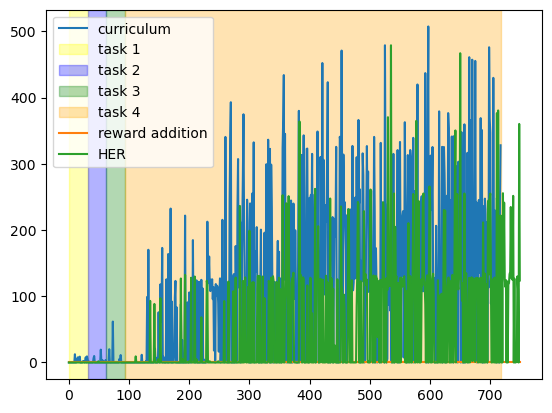

In [12]:
plt.plot(reward_main, label='curriculum')
plt.axvspan(0, task_length[0], color='yellow', alpha=0.3, label='task 1')
plt.axvspan(task_length[0], task_length[0]+task_length[1], color='blue', alpha=0.3, label='task 2')
plt.axvspan(task_length[0]+task_length[1], task_length[0]+task_length[1]+task_length[2], color='green', alpha=0.3, label='task 3')
if curriculum_length == 4:
    plt.axvspan(task_length[0]+task_length[1]+task_length[2], task_length[0]+task_length[1]+task_length[2]+task_length[3], color='orange', alpha=0.3, label='task 4')
plt.plot(reward_main_addition, label='reward addition')
plt.plot(reward_main_her, label='HER')
plt.legend()
plt.savefig(logger_path+"reward_main.png")

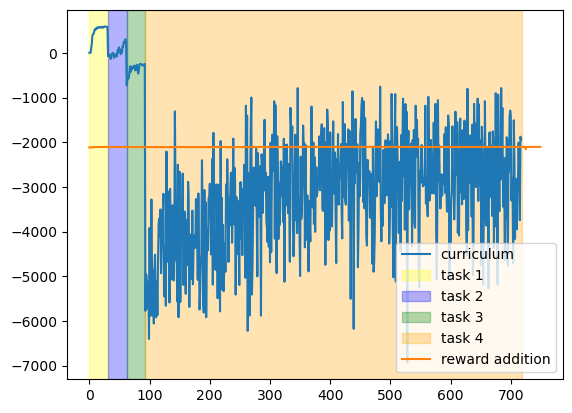

In [13]:
plt.plot(reward_task, label='curriculum')
plt.axvspan(0, task_length[0], color='yellow', alpha=0.3, label='task 1')
plt.axvspan(task_length[0], task_length[0]+task_length[1], color='blue', alpha=0.3, label='task 2')
plt.axvspan(task_length[0]+task_length[1], task_length[0]+task_length[1]+task_length[2], color='green', alpha=0.3, label='task 3')
if curriculum_length == 4:
    plt.axvspan(task_length[0]+task_length[1]+task_length[2], task_length[0]+task_length[1]+task_length[2]+task_length[3], color='orange', alpha=0.3, label='task 4')
plt.plot(reward_task_addition, label='reward addition')
plt.legend()
plt.savefig(logger_path+"reward_task.png")

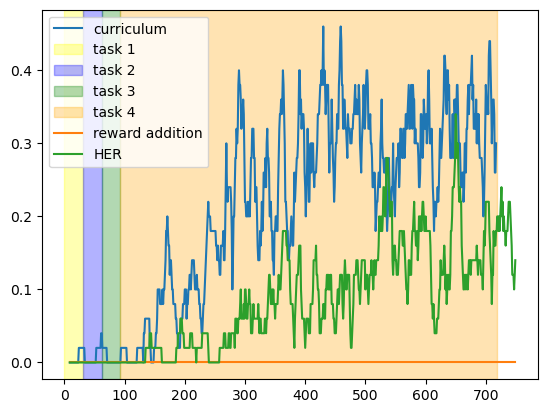

In [15]:
success_moving_avg = pd.Series(success).rolling(10).mean()
plt.plot(success_moving_avg, label='curriculum')
# plt.plot(success)
plt.axvspan(0, task_length[0], color='yellow', alpha=0.3, label='task 1')
plt.axvspan(task_length[0], task_length[0]+task_length[1], color='blue', alpha=0.3, label='task 2')
plt.axvspan(task_length[0]+task_length[1], task_length[0]+task_length[1]+task_length[2], color='green', alpha=0.3, label='task 3')
if curriculum_length == 4:
    plt.axvspan(task_length[0]+task_length[1]+task_length[2], task_length[0]+task_length[1]+task_length[2]+task_length[3], color='orange', alpha=0.3, label='task 4')
success_addition_avg = pd.Series(success_addition).rolling(10).mean()
plt.plot(success_addition_avg, label='reward addition')
# plt.plot([success_addition[4*i] for i in range(150)], label='reward addition')
success_her_avg = pd.Series(success_her).rolling(10).mean()
plt.plot(success_her_avg, label='HER')
plt.legend()
plt.savefig(logger_path+"success.png")

# Env Test

In [22]:
import Curriculum

# env = make_vec_env("Curriculum/Fetch_Push-v0")
env = gym.make("Curriculum/FetchPush-v2")

/global/home/users/kanghyunryu/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Curriculum/FetchPush-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(


In [24]:
obs = env.reset()
print(obs)

# model = SAC.load("./logs/AntMaze_UMaze_SAC/goal_orientation/sample_0/final_model.zip")

for i in range(100):
#     action, _states = model.predict(obs, deterministic=True)
    obs, rewards, _, _, info = env.step(env.action_space.sample())
    print(obs)
    for key in info.keys():
        print(key)

({'observation': array([ 1.34815922e+00,  7.48950902e-01,  4.13618685e-01,  1.44869081e+00,
        8.40500616e-01,  4.24702091e-01,  1.00531588e-01,  9.15497140e-02,
        1.10834063e-02, -1.50944836e-06,  1.25159772e-03, -8.82449685e-08,
        1.35761490e-07,  4.67863609e-15,  9.30919601e-04, -4.11979931e-05,
        3.89350461e-05,  5.03907166e-08, -7.75241793e-08,  2.87432303e-20,
       -9.30921536e-04,  4.11967353e-05,  7.89271962e-06,  3.79757618e-07,
        4.39314913e-05]), 'achieved_goal': array([1.44869081, 0.84050062, 0.42470209]), 'desired_goal': array([1.34272023, 0.63261554, 0.42469975])}, {})
{'observation': array([ 1.36081507e+00,  7.60986784e-01,  4.19396033e-01,  1.44869081e+00,
        8.40500615e-01,  4.24737381e-01,  8.78757393e-02,  7.95138314e-02,
        5.34134875e-03,  0.00000000e+00,  0.00000000e+00, -5.03884423e-08,
        7.75206804e-08,  6.42903866e-16, -1.49649158e-02, -1.22634187e-02,
        6.79749338e-04,  2.85323085e-08, -4.38958592e-08,  1.72

{'observation': array([ 1.33306178e+00,  7.98413568e-01,  5.35105631e-01,  1.44869081e+00,
        8.40500614e-01,  4.24784469e-01,  1.15629024e-01,  4.20870461e-02,
       -1.10321161e-01,  0.00000000e+00,  0.00000000e+00, -2.18063528e-11,
        3.35482376e-11, -1.30847765e-15,  1.06486510e-02,  2.58494435e-02,
       -4.20452402e-03,  1.22161635e-11, -1.87940951e-11, -3.08624005e-18,
       -1.06486510e-02, -2.58494435e-02,  4.20453510e-03,  6.45508971e-04,
        4.11692341e-04]), 'achieved_goal': array([1.44869081, 0.84050061, 0.42478447]), 'desired_goal': array([1.34272023, 0.63261554, 0.42469975])}
success
reward_dict
{'observation': array([ 1.34042582e+00,  7.76934826e-01,  5.56248696e-01,  1.44869081e+00,
        8.40500614e-01,  4.24784478e-01,  1.08264985e-01,  6.35657881e-02,
       -1.31464218e-01,  0.00000000e+00,  0.00000000e+00, -1.25496507e-11,
        1.93071640e-11, -1.30970085e-15, -8.58962043e-03,  1.30747733e-02,
       -1.74201210e-02,  7.03044179e-12, -1.08160

{'observation': array([ 1.39553219e+00,  7.90694138e-01,  5.08861714e-01,  1.44869081e+00,
        8.40500614e-01,  4.24784489e-01,  5.31586222e-02,  4.98064759e-02,
       -8.40772250e-02,  0.00000000e+00,  0.00000000e+00, -5.48305567e-15,
        8.44730990e-15, -1.30426443e-15, -1.55831618e-02,  7.79561766e-03,
        5.78746886e-03,  3.07516615e-15, -4.72883104e-15,  1.55257390e-18,
        1.55831618e-02, -7.79561766e-03, -5.78746886e-03,  1.97048401e-04,
        4.29740009e-04]), 'achieved_goal': array([1.44869081, 0.84050061, 0.42478449]), 'desired_goal': array([1.34272023, 0.63261554, 0.42469975])}
success
reward_dict
{'observation': array([ 1.39079051e+00,  8.20402411e-01,  5.21956556e-01,  1.44869081e+00,
        8.40500614e-01,  4.24784489e-01,  5.79002944e-02,  2.00982031e-02,
       -9.71720672e-02,  0.00000000e+00,  0.00000000e+00, -3.15132780e-15,
        4.85856439e-15, -1.30314760e-15,  7.74631491e-03, -2.66434626e-02,
       -1.24167415e-02,  1.76242489e-15, -2.72825

{'observation': array([ 1.34399108e+00,  7.73785379e-01,  5.43163545e-01,  1.44869080e+00,
        8.40500593e-01,  4.24784491e-01,  1.04699717e-01,  6.67152147e-02,
       -1.18379054e-01,  0.00000000e+00,  0.00000000e+00,  6.47853415e-07,
       -2.52923548e-07,  8.06233560e-14,  1.52633662e-02,  5.27143812e-03,
        6.52024763e-03, -3.62933034e-07,  1.41689938e-07,  6.63483493e-19,
       -1.52633627e-02, -5.27142905e-03, -6.52024849e-03,  4.01173791e-04,
        2.76210240e-05]), 'achieved_goal': array([1.4486908 , 0.84050059, 0.42478449]), 'desired_goal': array([1.34272023, 0.63261554, 0.42469975])}
success
reward_dict
{'observation': array([ 1.33590663e+00,  7.45475638e-01,  5.26677832e-01,  1.44869080e+00,
        8.40500600e-01,  4.24784490e-01,  1.12784175e-01,  9.50249627e-02,
       -1.01893342e-01,  0.00000000e+00,  0.00000000e+00,  3.72843286e-07,
       -1.45558925e-07,  2.58301733e-14,  3.69786026e-03,  2.30246341e-02,
        1.29197777e-02, -2.08870034e-07,  8.15433

{'observation': array([ 1.27279869e+00,  7.24979585e-01,  6.73384293e-01,  1.44869081e+00,
        8.40500610e-01,  4.24784489e-01,  1.75892114e-01,  1.15521024e-01,
       -2.48599803e-01,  0.00000000e+00,  0.00000000e+00,  1.63012009e-10,
       -6.36402926e-11, -1.30390250e-15,  3.85791675e-03, -1.97695560e-02,
        9.31375734e-03, -9.13207490e-11,  3.56518508e-11, -2.02050057e-18,
       -3.85791675e-03,  1.97695560e-02, -9.31375734e-03,  2.17435858e-04,
        1.41452958e-03]), 'achieved_goal': array([1.44869081, 0.84050061, 0.42478449]), 'desired_goal': array([1.34272023, 0.63261554, 0.42469975])}
success
reward_dict
{'observation': array([ 1.26696309e+00,  7.15851391e-01,  6.51653511e-01,  1.44869081e+00,
        8.40500610e-01,  4.24784489e-01,  1.81727713e-01,  1.24649219e-01,
       -2.26869022e-01,  0.00000000e+00,  0.00000000e+00,  9.38143170e-11,
       -3.66253419e-11, -1.30703901e-15,  4.17530565e-03,  1.17525797e-02,
        1.69486198e-02, -5.25555927e-11,  2.05178

{'observation': array([ 1.25185653e+00,  6.78286434e-01,  6.59400953e-01,  1.44869081e+00,
        8.40500610e-01,  4.24784489e-01,  1.96834280e-01,  1.62214176e-01,
       -2.34616464e-01,  0.00000000e+00,  0.00000000e+00,  4.10191132e-14,
       -1.60125918e-14, -1.30534673e-15, -1.74607510e-02,  6.09883666e-03,
        1.81805785e-03, -2.29788801e-14,  8.97120787e-15,  3.99931030e-18,
        1.74607510e-02, -6.09883666e-03, -1.81805785e-03,  1.98834565e-04,
        3.18041788e-04]), 'achieved_goal': array([1.44869081, 0.84050061, 0.42478449]), 'desired_goal': array([1.34272023, 0.63261554, 0.42469975])}
success
reward_dict
{'observation': array([ 1.25630279e+00,  7.01383103e-01,  6.54349177e-01,  1.44869081e+00,
        8.40500610e-01,  4.24784489e-01,  1.92388016e-01,  1.39117507e-01,
       -2.29564688e-01,  0.00000000e+00,  0.00000000e+00,  2.36111195e-14,
       -9.21719854e-15, -1.30292829e-15,  4.44111293e-06, -2.08620306e-02,
        3.87314895e-03, -1.32251613e-14,  5.16318

{'observation': array([ 1.24781424e+00,  5.78843340e-01,  6.51034895e-01,  1.44869081e+00,
        8.40500610e-01,  4.24784489e-01,  2.00876571e-01,  2.61657270e-01,
       -2.26250406e-01,  0.00000000e+00,  0.00000000e+00,  8.40282665e-17,
       -1.33471275e-17, -1.29910940e-15,  5.14767591e-03,  8.69616881e-03,
        1.02007481e-02, -3.55320355e-17,  7.76812544e-18, -4.36829619e-18,
       -5.14767591e-03, -8.69616881e-03, -1.02007481e-02,  2.63787947e-04,
        1.47727918e-04]), 'achieved_goal': array([1.44869081, 0.84050061, 0.42478449]), 'desired_goal': array([1.34272023, 0.63261554, 0.42469975])}
success
reward_dict
{'observation': array([ 1.26092879e+00,  5.85505356e-01,  6.69675998e-01,  1.44869081e+00,
        8.40500610e-01,  4.24784489e-01,  1.87762012e-01,  2.54995254e-01,
       -2.44891509e-01,  0.00000000e+00,  0.00000000e+00,  8.11346697e-17,
       -8.07269788e-18, -1.29889034e-15, -1.21317491e-02, -7.55212660e-03,
       -1.85601181e-02, -3.63309366e-17,  7.38875

In [ ]:
goal_pos = obs['desired_goal']
xyz_coord = obs['observation'][0][:3]
print(xyz_coord)
distance= np.linalg.norm(goal_pos - xyz_coord[:2])

distance

In [ ]:
-np.linalg.norm([1.3408, 0.75647, 0.41671] - [0.144742, 0.8211249, 0.42469975]) + 

In [ ]:
rewards

In [ ]:
model.policy